## 과제 3: 배우/감독 네트워크 분석 및 성공 패턴 발견
주요 배우와 감독들의 협업 관계를 네트워크로 시각화하고, 성공적인 콜라보레이션 패턴을 발견하여 캐스팅 전략에 대한 인사이트를 도출하세요.

,director,actor,n_collabs,avg_revenue,avg_roi,avg_net_profit,first_year,last_year
443,Bong Joon Ho,Song Kang-ho,3,1.442801e+08,10.975699,1.237591e+08,2006.0,2019.0
7505,Kim Yong-hwa,Ju Ji-hoon,2,1.193871e+08,6.523885,1.010871e+08,2017.0,2018.0
7510,Kim Yong-hwa,Kim Hyang-gi,2,1.193871e+08,6.523885,1.010871e+08,2017.0,2018.0
5501,Kim Han-min,Ryu Seung-ryong,2,9.367113e+07,10.343671,8.492113e+07,2011.0,2014.0
9597,Lee Sang-yong,Don Lee,2,9.228850e+07,13.311409,8.848850e+07,2022.0,2023.0
...,...,...,...,...,...,...,...,...
14667,Zhang Lu,Han Yeri,2,0.000000e+00,NaN,0.000000e+00,2015.0,2016.0
14678,Zhang Lu,Moon So-ri,2,0.000000e+00,NaN,0.000000e+00,2015.0,2018.0
14683,Zhang Lu,Park So-dam,2,0.000000e+00,NaN,0.000000e+00,2018.0,2020.0
14761,오재학,Lee Da-min,2,0.000000e+00,NaN,0.000000e+00,2017.0,2017.0


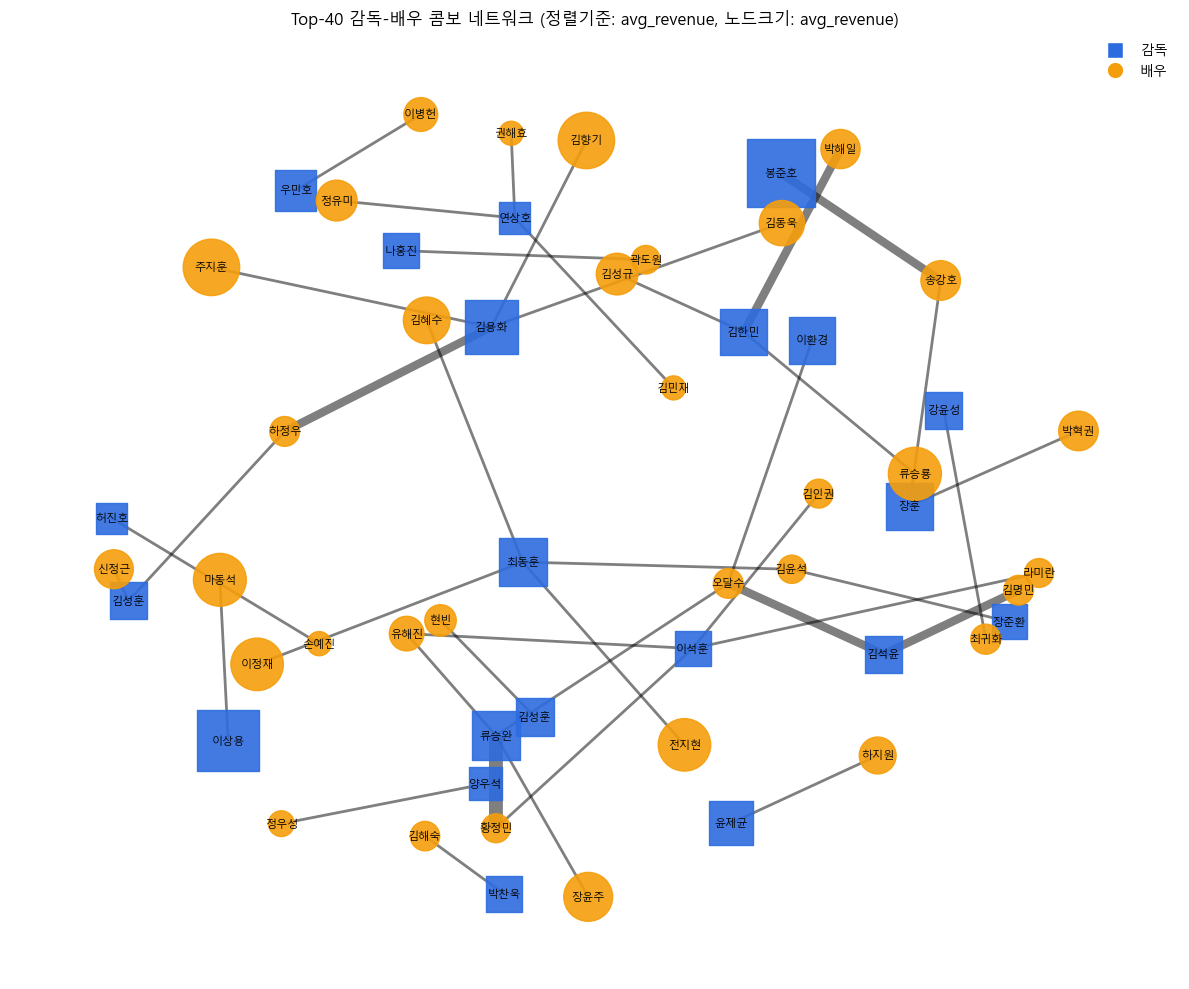

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import islice
from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


# === 영문 -> 한글 이름 매핑 (필요시 계속 추가) ===
name_map = {
    # 감독
    "Bong Joon Ho": "봉준호",
    "Park Chan-wook": "박찬욱",
    "Choi Dong-hoon": "최동훈",
    "Kim Yong-hwa": "김용화",
    "Jang Hoon": "장훈",
    "Lee Hwan-kyung": "이환경",
    "JK Youn": "윤제균", "J.K. Youn": "윤제균",
    "Ryoo Seung-wan": "류승완", "Ryu Seung-wan": "류승완",
    "Na Hong-jin": "나홍진",
    "Woo Min-ho": "우민호",
    "Yang Woo-seok": "양우석",
    "Lee Suk-hoon": "이석훈",
    "Lee Sang-yong": "이상용",
    "Kim Han-min": "김한민",
    "Kim Seong-hun": "김성훈", "Kim Sung-hoon": "김성훈",
    "Kang Yun-sung": "강윤성",
    "Kim Sok-yun": "김석윤",
    "Park Hoon-jung": "박훈정",
    "Jang Joon-hwan": "장준환",

    # 배우
    "Song Kang-ho": "송강호",
    "Lee Byung-hun": "이병헌",
    "Don Lee": "마동석", "Ma Dong-seok": "마동석",
    "Hyun Bin": "현빈",
    "Ha Jung-woo": "하정우",
    "Lee Jung-jae": "이정재",
    "Ryu Seung-ryong": "류승룡",
    "Kwak Do-won": "곽도원",
    "Oh Dal-su": "오달수",
    "Yoo Hae-jin": "유해진",
    "Hwang Jung-min": "황정민",
    "Jung Woo-sung": "정우성",
    "Kim Hye-soo": "김혜수",
    "Jun Ji-hyun": "전지현",
    "Son Ye-jin": "손예진",
    "Park Hae-il": "박해일",
    "Joo Ji-hoon": "주지훈", "Ju Ji-hoon": "주지훈",
    "Jung Yu-mi": "정유미",
    "Kim Yoon-seok": "김윤석",
    "Kim Hyang-gi": "김향기",
    "Ra Mi-ran": "라미란",
    "Kim Min-jae": "김민재",
    "Kim In-kwon": "김인권",
    "Shin Jung-keun": "신정근",
    "Kim Hae-sook": "김해숙",
    "Park Hyuk-kwon": "박혁권",
    "Kim Sung-kyu": "김성규",
    "Hur Jin-ho": "허진호",
    "Kwon Hae-hyo": "권해효",
    "Yeon Sang-ho": "연상호",
    "Jang Yoon-ju": "장윤주",
    "Kim Myung-min": "김명민",
    "Cho Gwi-hwa": "조귀화",
    "Kim Dong-wook": "김동욱",
    'Choi Gwi-hwa': "최귀화", 
    'Ha Ji-won': "하지원",
    'Kim Yun-seok': "김윤석",
    'Yoo Hai-jin': "유해진",
}


# =========================
# 0) 데이터 로드 & 전처리
# =========================
PATH = "./data_processed/tmdb_with_credits.csv"   # 경로 확인

df = pd.read_csv(PATH)

num_cols = ["release_year","budget","revenue","vote_average","runtime"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 기간 필터
if "release_year" in df.columns:
    df = df[df["release_year"].between(2005, 2025)]

# ROI/순이익
df["roi"] = np.where((df["budget"]>0) & (df["revenue"]>0),
                     df["revenue"]/df["budget"], np.nan)
df["net_profit"] = df["revenue"] - df["budget"]

# 배우 파싱
def parse_actors(s):
    return [x.strip() for x in str(s).split(",") if x.strip()]
df = df.dropna(subset=["director","actors"])
df["actors_list"] = df["actors"].apply(parse_actors)

# ===========================================
# 1) 감독-배우 엣지 생성 → 콤보 성과 집계
# ===========================================
TOP_N_CAST  = 5     # 배우 상위 N명만 사용(전체 쓰려면 None)
MIN_COLLABS = 2     # 최소 협업 편수
METRIC_EDGE_ORDER = "avg_revenue"  # 네트워크 상위 콤보 선정 기준: avg_net_profit or avg_roi
TOP_K_EDGES = 40    # 시각화할 상위 콤보 수

def topN(lst, n):
    return list(islice(lst, n)) if (n and n>0) else lst

rows = []
for _, r in df.iterrows():
    director = r["director"]
    for actor in topN(r["actors_list"], TOP_N_CAST):
        rows.append({
            "director": director,
            "actor": actor,
            "movie_id": r.get("movie_id"),
            "title": r.get("title"),
            "release_year": r.get("release_year"),
            "revenue": r.get("revenue"),
            "budget": r.get("budget"),
            "roi": r.get("roi"),
            "net_profit": r.get("net_profit"),
        })

edges = (pd.DataFrame(rows)
         .groupby(["director","actor"], as_index=False)
         .agg(n_collabs=("movie_id","nunique"),
              avg_revenue=("revenue","mean"),
              avg_roi=("roi","mean"),
              avg_net_profit=("net_profit","mean"),
              first_year=("release_year","min"),
              last_year=("release_year","max"))
         .query("n_collabs >= @MIN_COLLABS")
         .sort_values([METRIC_EDGE_ORDER,"n_collabs"], ascending=[False, False])
        )

display(edges)

# 상위 TOP_K_EDGES만 서브그래프 구성
sub = edges.head(TOP_K_EDGES).copy()

# =========================
# 2) 그래프 구성
# =========================
G = nx.Graph()
for _, r in sub.iterrows():
    u = ("director", r["director"])
    v = ("actor",    r["actor"])
    G.add_node(u, role="director")
    G.add_node(v, role="actor")
    # 협업 횟수(weight)와 콤보 성과(metric) 저장
    G.add_edge(u, v, weight=int(r["n_collabs"]),
                  avg_revenue=float(r["avg_revenue"]) if pd.notna(r["avg_revenue"]) else 0.0,
                  avg_net_profit=float(r["avg_net_profit"]) if pd.notna(r["avg_net_profit"]) else 0.0,
                  avg_roi=float(r["avg_roi"]) if pd.notna(r["avg_roi"]) else 0.0)

# =========================
# 3) 시각화 설정
# =========================
# 레이아웃
pos = nx.spring_layout(G, seed=42, k=0.8)

# 노드 리스트
directors = [n for n, d in G.nodes(data=True) if d["role"] == "director"]
actors    = [n for n, d in G.nodes(data=True) if d["role"] == "actor"]

# --------- (A) 엣지 굵기: 협업 횟수 min-max 정규화로 대비 강화 ----------
w = [G.edges[e]["weight"] for e in G.edges()]
w_min, w_max = min(w), max(w)
if w_max == w_min:
    edge_widths = [6 for _ in w]  # 모두 동일한 경우
else:
    edge_widths = [ 2 + 8*((val - w_min)/(w_max - w_min)) for val in w ]  # 2~10 범위

# --------- (B) 노드 크기: 흥행 지표 기반 ----------
# 여기서 무엇으로 스케일링할지 선택
METRIC_NODE_SIZE = "avg_revenue"   # "avg_net_profit" 또는 "avg_revenue"

# 노드별 metric 주입 (해당 콤보에서의 지표를 노드로 복사)
for _, r in sub.iterrows():
    G.nodes[("director", r["director"])][METRIC_NODE_SIZE] = r[METRIC_NODE_SIZE]
    G.nodes[("actor",    r["actor"])][METRIC_NODE_SIZE] = r[METRIC_NODE_SIZE]

# 노드 metric dict 추출
metric_map = {n: G.nodes[n].get(METRIC_NODE_SIZE, 0) for n in G.nodes()}
vals = np.array([0 if pd.isna(metric_map[n]) else float(metric_map[n]) for n in G.nodes()])
# 로그 스케일 후 정규화
vals_log = np.log1p(np.abs(vals))
vmin, vmax = float(np.nanmin(vals_log)), float(np.nanmax(vals_log))
if vmax == vmin:
    norm = {n: 0.5 for n in G.nodes()}
else:
    norm = {n: (np.log1p(abs(metric_map[n])) - vmin) / (vmax - vmin) for n in G.nodes()}

# 크기 범위(배우/감독 다르게)
MIN_SIZE_ACT, MAX_SIZE_ACT = 300, 1800
MIN_SIZE_DIR, MAX_SIZE_DIR = 500, 2400
size_map = {}
for n, data in G.nodes(data=True):
    x = norm[n]  # 0~1
    if data["role"] == "director":
        size_map[n] = MIN_SIZE_DIR + x*(MAX_SIZE_DIR - MIN_SIZE_DIR)
    else:
        size_map[n] = MIN_SIZE_ACT + x*(MAX_SIZE_ACT - MIN_SIZE_ACT)

# =========================
# 4) 그리기
# =========================
plt.figure(figsize=(12,10))

# 엣지
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5)

# 감독: 파란 사각형
nx.draw_networkx_nodes(
    G, pos,
    nodelist=directors,
    node_size=[size_map[n] for n in directors],
    node_color="#2D6CDF",
    node_shape="s",
    alpha=0.9
)

# 배우: 주황 원형
nx.draw_networkx_nodes(
    G, pos,
    nodelist=actors,
    node_size=[size_map[n] for n in actors],
    node_color="#F59E0B",
    node_shape="o",
    alpha=0.9
)

# 라벨
# 라벨 만들 때 매핑 적용
labels = {n: name_map.get(n[1], n[1]) for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_family="Malgun Gothic")

plt.title(f"Top-{TOP_K_EDGES} 감독-배우 콤보 네트워크 "
          f"(정렬기준: {METRIC_EDGE_ORDER}, 노드크기: {METRIC_NODE_SIZE})")
plt.axis("off")

# 범례
from matplotlib.lines import Line2D
legend_elems = [
    Line2D([0],[0], marker='s', color='w', label='감독',
           markerfacecolor='#2D6CDF', markersize=12),
    Line2D([0],[0], marker='o', color='w', label='배우',
           markerfacecolor='#F59E0B', markersize=12)
]
plt.legend(handles=legend_elems, loc="best", frameon=False)
plt.tight_layout()
plt.show()

이 상태로 과제3 결론 문장 뽑을 때는:

굵은 선(협업 34회) + 큰 노드(흥행 규모↑) 콤보를 중심으로 사례 35개 선정

각 콤보의 장르/시기 공통점 1–2줄, 흥행 수치(평균 매출/순익) 1줄

캐스팅 제안: “○○감독–△△배우 라인은 액션/범죄 장르에서 평균 매출 △△억, 협업 3회 이상 → 차기편에서도 유효 가능성 높음” 처럼